### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [3]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()
# !pip install -Uq transformers

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *

import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

### **GPT2 MODEL:**
- There are several versions of **GPT2 Model** : [**Transformers Documentation**](https://huggingface.co/transformers/pretrained_models.html). I will inspect the **Tokenizer** and **Model**. The **Tokenizers** in **HuggingFace** usually do the tokenization and numericalization in one step. The **Model** can generate predictions. 

In [6]:
#@ LOADING PRETRAINED MODEL: 
pretrained_weights = "gpt2"                                         # Initialization. 
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)   # Initializing Tokenizer. 
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)         # Initializing Pretrained Model. 

In [7]:
#@ INSPECTING TOKENIZER: 
ids = tokenizer.encode("Hello there! How are you?")                 # Implementation of Tokenizer. 
print(ids)                                                          # Inspection. 
tokenizer.decode(ids)                                               # Getting Text. 

[15496, 612, 0, 1374, 389, 345, 30]


'Hello there! How are you?'

In [8]:
#@ INSPECTING PREDICTIONS: 
t = torch.LongTensor(ids)[None]                                     # Initializing 1D Tensor. 
preds = model.generate(t)                                           # Generating Predictions. 
preds.shape, preds[0]                                               # Inspection. 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


(torch.Size([1, 20]),
 tensor([15496,   612,     0,  1374,   389,   345,    30,   198,   198,    40,  1101,   257,  1310,  1643, 10032,   286,   262,  6678,  3404,    13]))

In [9]:
#@ INSPECTING PREDICTIONS: 
tokenizer.decode(preds[0].numpy())                                  # Inspection. 

"Hello there! How are you?\n\nI'm a little bit tired of the usual stuff."

### **PREPARING DATA:**
- I will use **wikitext-2** dataset here. 

In [11]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.WIKITEXT_TINY)                   # Initializing Path to Dataset. 
path.ls()                                               # Inspection.                           

(#2) [Path('/root/.fastai/data/wikitext-2/test.csv'),Path('/root/.fastai/data/wikitext-2/train.csv')]

In [12]:
#@ LOADING THE DATASET: 
df_train = pd.read_csv(path/"train.csv", header=None)   # Reading the Data.
df_valid = pd.read_csv(path/"test.csv", header=None)    # Reading the Data. 
df_train.head(2)                                        # Inspecting the Data. 

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."


In [13]:
#@ LOADING THE DATA:
all_texts = np.concatenate([df_train[0].values, 
                            df_valid[0].values])        # Initializing Concatenation. 

### **TRANSFORMERS TOKENIZER:**

**TRANSFORM METHOD:**  
**Fastai Transform** is defined as:     
- an **encodes** method that is applied when **transform** is called. 
- a **decodes** method that is applied when **decode** method of transform is called. 
- a **setups** method that sets inner state of **Transform**. 

In [14]:
#@ DEFINING TRANSFORMERS TOKENIZER: 
class TransformersTokenizer(Transform):                     # Defining Tokenizer. 
    def __init__(self, tokenizer):                          # Initializing Constructor Function. 
        self.tokenizer = tokenizer                          # Initializing Tokenizer. 
    
    def encodes(self, x):                                   # Initializing Encode Method. 
        toks = self.tokenizer.tokenize(x)                   # Initializing Tokenizer. 
        return tensor(
            self.tokenizer.convert_tokens_to_ids(toks))     # Generating IDs. 
    
    def decodes(self, x):                                   # Initializing Decode Method. 
        return TitledStr(
            self.tokenizer.decode(x.cpu().numpy()))

In [16]:
#@ IMPLEMENTATION OF TRANSFORM METHOD: 
splits = [range_of(df_train), 
          list(range(len(df_train), len(all_texts)))]       # Initialization. 
tls = TfmdLists(all_texts,TransformersTokenizer(tokenizer), 
                splits=splits, dl_type=LMDataLoader)        # Initializing Transformed DataLoader. 

#@ INSPECTING TRANSFORMED DATALOADER: 
print(tls.train[0], tls.valid[0])
print(tls.tfms(tls.train.items[0]).shape, 
      tls.tfms(tls.valid.items[0]).shape)

tensor([220, 198, 796,  ..., 198, 220, 198]) tensor([220, 198, 796,  ..., 198, 220, 198])
torch.Size([4576]) torch.Size([1485])


In [17]:
#@ INSPECTING THE DECODES: 
show_at(tls.train, 0)

 
 = 2013 – 14 York City F.C. season = 
 
 The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club, a professional football club based in York, North Yorkshire, England. Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two. The season ran from 1 July 2013 to 30 June 2014. 
 Nigel Worthington, starting his first full season as York manager, made eight permanent summer signings. By the turn of the year York were only above the relegation zone on goal difference, before a 17 @-@ match unbeaten run saw the team finish in seventh @-@ place in the 24 @-@ team 2013 – 14 Football League Two. This meant York qualified for the play @-@ offs, and they were eliminated in the semi @-@ final by Fleetwood Town. York were knocked out of the 2013 – 14 FA Cup, Football League Cup and Football League Trophy in their opening round matches. 
 35 players made at least

In [18]:
#@ INSPECTING THE DECODES: 
show_at(tls.valid, 0)

 
 = Tropical Storm <unk> ( 2008 ) = 
 
 Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season. <unk> developed out of a strong tropical wave which moved off the African coast on August 31. The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2. The depression was quickly upgraded to Tropical Storm <unk> around noon the same day. Over the next several days, <unk> moved in a general west @-@ northwest direction and reached its peak intensity early on September 3. Strong wind shear, some due to the outflow of Hurricane Ike, and dry air caused the storm to weaken. On September 6, the combination of wind shear, dry air, and cooling waters caused <unk> to weaken into a tropical depression. <unk> deteriorated into a remnant low shortly after as convection continued to dissipate around the storm. The low ultimately dissipated while located 5

### **INITIALIZING DATALOADERS:**
- I will assemble the data in **DataLoaders** object. 

In [19]:
#@ INITIALIZING DATALOADERS: 
bs, sl = 4, 256                             # Initialization. 
dls = tls.dataloaders(bs=bs, seq_len=sl)    # Initializing DataLoader. 

#@ INSPECTING DATALOADERS: 
dls.show_batch(max_n=2)                     # Inspection. 

,text,text_
0,"\n = Richard Nixon presidential campaign, 1968 = \n \n The 1968 presidential campaign of Richard Nixon, the 36th Vice President of the United States, began when Nixon, the Republican nominee of 1960, formally announced his candidacy following a year's preparation and five years'political <unk> following defeats in the 1960 presidential election, and the 1962 California gubernatorial election. \n <unk> route to the Republican Party's presidential nomination, Nixon faced challenges from Governor George Romney of Michigan, Governor Nelson Rockefeller of New York, Governor Ronald Reagan of California, and Senator Charles Percy of Illinois. Nixon won nine of the thirteen state primaries held that season, although due to the population of his state, Governor Reagan won the popular vote while carrying only California. These victories, along with pledged delegate support from states not holding primaries, secured Nixon the nomination on the first ballot of the Republican National Convention, where he","\n = Richard Nixon presidential campaign, 1968 = \n \n The 1968 presidential campaign of Richard Nixon, the 36th Vice President of the United States, began when Nixon, the Republican nominee of 1960, formally announced his candidacy following a year's preparation and five years'political <unk> following defeats in the 1960 presidential election, and the 1962 California gubernatorial election. \n <unk> route to the Republican Party's presidential nomination, Nixon faced challenges from Governor George Romney of Michigan, Governor Nelson Rockefeller of New York, Governor Ronald Reagan of California, and Senator Charles Percy of Illinois. Nixon won nine of the thirteen state primaries held that season, although due to the population of his state, Governor Reagan won the popular vote while carrying only California. These victories, along with pledged delegate support from states not holding primaries, secured Nixon the nomination on the first ballot of the Republican National Convention, where he named"
1,"takeover by the chamber of commerce also proved to be successful, as the 1986 game made a small profit. This was an improvement over the three previous Peach <unk>, which lost more than $ 170 @,@ 000. The sellout also confirmed that the game would continue to be held annually instead of being abandoned, as sportswriters had speculated prior to the 1986 game. \n Tech kicker Chris Kinzer, who kicked the game @-@ winning field goal, did not go on to play in the National Football League despite predictions that he might do so. He attended several NFL teams'<unk>, but a contract to play in the league never materialized. He sold insurance for several years, then <unk> school and graduated from Virginia Tech in 1994 with a degree. \n \n = = Later aftermath = = \n \n Virginia Tech would go on to join the Atlantic Coast Conference,","by the chamber of commerce also proved to be successful, as the 1986 game made a small profit. This was an improvement over the three previous Peach <unk>, which lost more than $ 170 @,@ 000. The sellout also confirmed that the game would continue to be held annually instead of being abandoned, as sportswriters had speculated prior to the 1986 game. \n Tech kicker Chris Kinzer, who kicked the game @-@ winning field goal, did not go on to play in the National Football League despite predictions that he might do so. He attended several NFL teams'<unk>, but a contract to play in the league never materialized. He sold insurance for several years, then <unk> school and graduated from Virginia Tech in 1994 with a degree. \n \n = = Later aftermath = = \n \n Virginia Tech would go on to join the Atlantic Coast Conference, which"


**Note:**
- Another method to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts. 

In [20]:
#@ DEFINING TRANSFORMERS TOKENIZER: 
def tokenize(text):                                         # Defining Tokenize Function. 
    toks = tokenizer.tokenize(text)                         # Initializing Tokens. 
    return tensor(tokenizer.convert_tokens_to_ids(toks))    # Initializing Tensors of IDs. 
tokenized = [tokenize(t) for t in progress_bar(all_texts)]  # Implementation of Tokenize Method. 

#@ DEFINING TRANSFORMERS TOKENIZER: 
class TransformersTokenizer(Transform):                     # Defining Tokenizer. 
    def __init__(self, tokenizer):                          # Initializing Constructor Function. 
        self.tokenizer = tokenizer                          # Initializing Tokenizer. 
    
    def encodes(self, x):                                   # Defining Encodes Method. 
        return x if isinstance(x,Tensor) else tokenize(x)   # Implementation of Tokenize Function. 
    
    def decodes(self, x):                                   # Defining Decodes Method. 
        return TitledStr(
            self.tokenizer.decode(x.cpu().numpy()))         # Implementation of Tokenizer. 

In [21]:
#@ INITIALIZING DATALOADERS: 
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), 
                splits=splits, dl_type=LMDataLoader)            # Initializing Transformed Tokens. 
dls = tls.dataloaders(bs=bs, seq_len=sl)                        # Initializing DataLoader. 

#@ INSPECTING DATALOADERS: 
dls.show_batch(max_n=2)                                         # Inspection. 

,text,text_
0,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga. Released in Japan on March 3, 2010, it contains remixes of the songs from her first studio album, The Fame ( 2008 ), and her third extended play, The Fame Monster ( 2009 ). A revised version of the track list was prepared for release in additional markets, beginning with Mexico on May 3, 2010. A number of recording artists have produced the songs, including Pet Shop Boys, Passion Pit and The Sound of Arrows. The remixed versions feature both uptempo and <unk> compositions, with altered vocals from Gaga. \n The album received mixed reviews from contemporary critics, but some noted how Gaga was able to sell the songs from The Fame in new and novel ways. It reached the top of charts in Greece","\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga. Released in Japan on March 3, 2010, it contains remixes of the songs from her first studio album, The Fame ( 2008 ), and her third extended play, The Fame Monster ( 2009 ). A revised version of the track list was prepared for release in additional markets, beginning with Mexico on May 3, 2010. A number of recording artists have produced the songs, including Pet Shop Boys, Passion Pit and The Sound of Arrows. The remixed versions feature both uptempo and <unk> compositions, with altered vocals from Gaga. \n The album received mixed reviews from contemporary critics, but some noted how Gaga was able to sell the songs from The Fame in new and novel ways. It reached the top of charts in Greece and"
1,"1, 2 and 3 – to be a reflection of the mod aspect of 1960s British spy fiction. She also highlights Gray's homage to – and divergence from – musical norms, commenting that his score "" sends up the spy and action / adventure conventions of the'60s very <unk> and subtly "". \n David <unk> identifies <unk> homage in both the theme music and the series'premise. <unk> that the theme's opening string <unk> is similar in effect to a recurring motif in Ride of the <unk>, he also <unk> the Thunderbird machines to <unk> themselves : "" Their function is more benevolent than those warrior <unk>, but they do <unk> over danger, death and destruction. "" Kevin J. Donnelly of the University of Southampton acknowledges the series'"" big @-@ sounding orchestral score "", which he compares to that of a live @-@ action film. He also suggests that the",", 2 and 3 – to be a reflection of the mod aspect of 1960s British spy fiction. She also highlights Gray's homage to – and divergence from – musical norms, commenting that his score "" sends up the spy and action / adventure conventions of the'60s very <unk> and subtly "". \n David <unk> identifies <unk> homage in both the theme music and the series'premise. <unk> that the theme's opening string <unk> is similar in effect to a recurring motif in Ride of the <unk>, he also <unk> the Thunderbird machines to <unk> themselves : "" Their function is more benevolent than those warrior <unk>, but they do <unk> over danger, death and destruction. "" Kevin J. Donnelly of the University of Southampton acknowledges the series'"" big @-@ sounding orchestral score "", which he compares to that of a live @-@ action film. He also suggests that the music"


### **FINETUNING THE MODEL:**

In [22]:
#@ DEFINING THE CALLBACK: 
class DropOutput(Callback):                                         # Defining Callback. 
    def after_pred(self):
        self.learn.pred = self.pred[0]                              # Generating Only Predictions. 

**Note:**
- Since it is a **Language Model**, I will pass perplexity as a metric. **Perplexity** is the exponential of the **cross entropy loss function**. 

In [23]:
#@ INITIALIZING LEARNER: 
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                cbs=[DropOutput],metrics=Perplexity()).to_fp16()    # Initializing Learner. 
learn.validate()                                                    # Inspecting Model. 

(#2) [3.696233034133911,40.29522705078125]

SuggestedLRs(valley=6.30957365501672e-05)

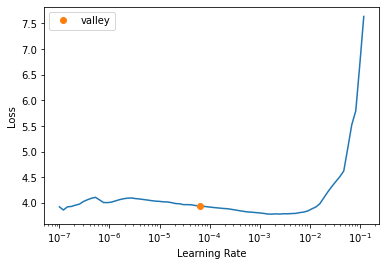

In [24]:
#@ INITIALIZING LR FINDER: 
learn.lr_find()

In [25]:
#@ TRAINING THE MODEL: 
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.069389,2.846193,17.222094,42:22


**MODEL EVALUATION:**

In [26]:
#@ INITIALIZING MODEL EVALUATION: 
prompt = "\n = Plane Crash = \n \n There are many reasons of plane crash"   # Example
prompt_ids = tokenizer.encode(prompt)                                       # Initializing Tokenization. 
inp = tensor(prompt_ids)[None].cuda()                                       # Generating Tensors. 
print(inp.shape)                                                            # Inspection. 

torch.Size([1, 16])


In [28]:
#@ INITIALIZING MODEL EVALUATION: 
preds = learn.model.generate(inp, max_length=40, num_beams=5, 
                             temperature=1.5)                               # Initializing Model Predictions. 
tokenizer.decode(preds[0].cpu().numpy())                                    # Inspecting Predictions. 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n = Plane Crash = \n \n There are many reasons of plane crash. One of the most common reasons is that the aircraft was not flying at the time of the crash. Another reason is'